# SFINCS Model setup

We want to combine data from the SRTM of resolution 30 m with data by Lin et al. for the river widths.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

import hydromt
import hydromt_sfincs
from hydromt.config import configread
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

logger = setuplog("prepare data catalog", log_level=10)

2024-03-11 11:10:59,954 - prepare data catalog - log - INFO - HydroMT version: 0.9.4


**Steps followed in this notebook to build your SFINCS model:**
<ol> 
<li> Open SfincsModel class, set data library and output folder </li>
<li> Specify characteristics of the wanted grid </li>
<li> Load in wanted elevation datasets </li>
<li> Make mask of active and inactive cells </li>
<li> Update mask with water level and outflow boundary cells</li>
<li> Add spatially varying roughness data</li>
<li> Make subgrid derived tables</li>
<li> Add spatially varying infiltration data</li>
<li> Add water level time-series as forcing</li>
<li> Add an upstream discharge time-series as forcing</li>
<li> Add spatially varying rainfall data</li>
<li> Add weirfile</li>
<li> Add observation points</li>
<li> Add observation lines</li>
<li> Show model</li>
<li> Save all files</li>
</ol> 

### 1. Initialize SfincsModel class, set data library and output folder:

In [2]:
model_root = Path(r"model")
data_libs = [
    Path(r"data/1_static/data_static_garissa.yml"),
    #Path(r"data/2_forcing/data_forcing.yml"),
]
base_root = Path(r"model/base")

data_catalog = hydromt.DataCatalog(data_libs=data_libs, logger=logger)

2024-03-11 11:10:59,977 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_garissa.yml


### 2. Specify characteristics of the wanted grid and generate grid:

In [3]:
# bbox = [36.6209722222222140, -3.1540277777777708,
#          41.5604166666666472, 0.4798611111111084]
# region = {"bbox": bbox}

model = SfincsModel(root=base_root, data_libs=data_libs, logger=logger)

2024-03-11 11:11:00,075 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_garissa.yml
2024-03-11 11:11:00,094 - prepare data catalog - log - DEBUG - Appending log messages to file c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\base\hydromt.log.
2024-03-11 11:11:00,095 - prepare data catalog - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


{'mmax': 100, 'nmax': 600, 'dx': 0.001, 'dy': 0.0005, 'x0': 39.65672889606923, 'y0': -0.6045884215259317, 'rotation': 28, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 4326}


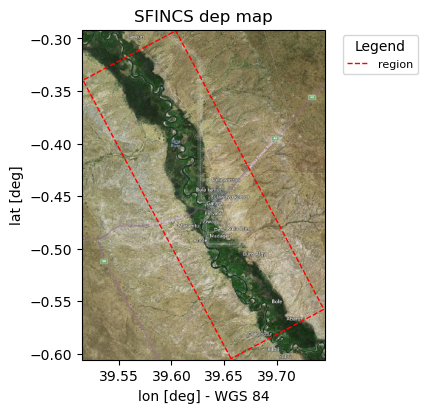

In [4]:
# model.setup_grid_from_region(
#     region=region,
#     res=0.01,
#     crs=4326,
#     hydrography_fn="srtm30"
#     )

model.setup_grid(
    x0=39.65672889606923,
    y0=-0.6045884215259317,
    dx=0.001,
    dy=0.0005,
    nmax=600,
    mmax=100,
    rotation=28,
    epsg=4326,
)

print(model.config)
_ = model.plot_basemap(plot_region=True, bmap="sat", zoomlevel=12)

### 3. Load in wanted elevation datasets:

2024-03-11 11:11:03,318 - prepare data catalog - rasterdataset - INFO - Reading srtm30 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\srtm30\STRM30DEM_garissa.tif


2024-03-11 11:11:03,390 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.516, -0.605, 39.745, -0.293] (epsg:4326))
2024-03-11 11:11:03,741 - prepare data catalog - merge - DEBUG - Reprojection method of first dataset is: average
2024-03-11 11:11:03,741 - prepare data catalog - sfincs - WARNING - Interpolate elevation at 770 cells
Plotting
2024-03-11 11:11:03,991 - prepare data catalog - rasterdataset - INFO - Reading srtm30 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\srtm30\STRM30DEM_garissa.tif
<xarray.DataArray 'STRM30DEM_garissa' (y: 1459, x: 1004)> Size: 3MB
dask.array<getitem, shape=(1459, 1004), dtype=int16, chunksize=(1459, 1004), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 8kB 39.47 39.47 39.47 39.47 ... 39.75 39.75 39.75
  * y            (y) float64 12kB -0.1994 -0.1997 -0.2 ... -0.6042 -0.6044
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:             Area
    DataType:  

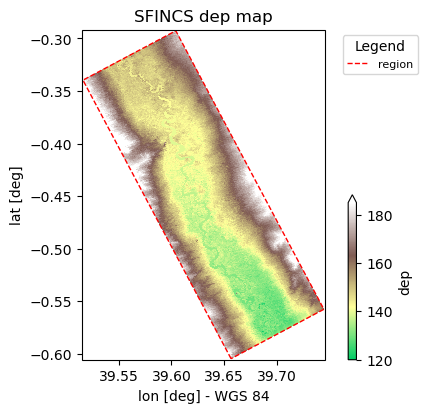

In [5]:
datasets_dep = [{"elevtn": "srtm30"}]
model.setup_dep(datasets_dep = datasets_dep)

print("Plotting")
_ = model.plot_basemap(variable="dep", plot_region=True)

# Also print some statistics
dem = data_catalog.get_rasterdataset("srtm30")
print(dem)

### 4. Make mask of active and inactive cells:


2024-03-11 11:11:04,809 - prepare data catalog - regulargrid - INFO - 0 gaps outside valid elevation range < 10.0 km2.
2024-03-11 11:11:04,809 - prepare data catalog - sfincs - INFO - Derive region geometry based on active cells.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


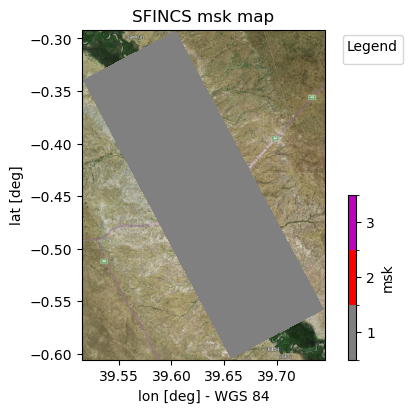

In [6]:
model.setup_mask_active(zmin=120, reset_mask=True)
# _ = model.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

### 5. Update mask with water level and outflow boundary cells - including use of polygons:

Performed after the river generation (5), since the river generation removes intersecting boundaries.

In [7]:
# model.setup_mask_bounds(btype="outflow", zmax=140, reset_bounds=True)

# # # Make a plot of the mask file
# _ = model.plot_basemap(variable="msk", plot_bounds=True)

### 6. Add river inflow/outflow points:

In [8]:
# derive river from hydrography data based on a minimum river length (river_len)
# and minimum upstream area (river_upa)
river_len = 0.1 # km
river_upa = 100 # km2
river_width = 150 # m

model.setup_river_inflow(
    hydrography="merit_hydro", 
    river_len=river_len, 
    river_upa=river_upa, 
    river_width=river_width, 
    keep_rivers_geom=True
)

2024-03-11 11:11:06,827 - prepare data catalog - rasterdataset - INFO - Reading merit_hydro raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\{variable}.tif
2024-03-11 11:11:06,843 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\flwdir.tif
2024-03-11 11:11:06,858 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\merit_hydro\uparea.tif


2024-03-11 11:11:06,879 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.516, -0.605, 39.745, -0.293] (epsg:4326))
2024-03-11 11:11:11,107 - prepare data catalog - sfincs - INFO - Found 2 river inflow points.


2024-03-11 11:11:11,165 - prepare data catalog - regulargrid - DEBUG - outflow (mask=3) boundary cells reset.


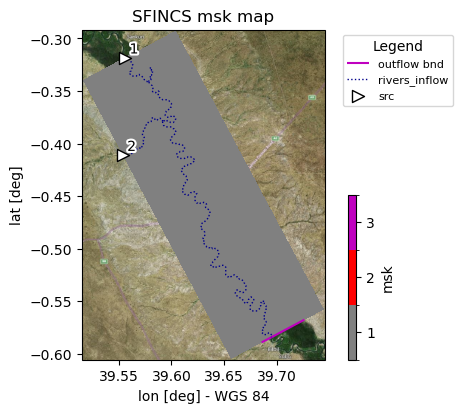

In [9]:
# Outflow boundary
model.setup_mask_bounds(btype="outflow", zmax=140, reset_bounds=True)

# Make a plot of model
# note the src points and derived river network
fig, ax = model.plot_basemap(variable="msk", plot_bounds=True, bmap="sat", zoomlevel=12)

In [16]:
gdf_riv = model.geoms["rivers_inflow"].copy()

print(gdf_riv)

gdf_riv["rivbed"]   = "srtm30"
# gdf_riv["mask"]     = "grwl_mask"
gdf_riv["manning"]  = 0.03  # manning coefficient [s.m-1/3]
# gdf_riv[["geometry", "rivwth", "rivdph", "manning"]]

datasets_riv = [{"centerlines": gdf_riv, "mask": "grwl_mask"}]


                                            geometry    idx  idx_ds    pit  \
4  LINESTRING (39.59167 -0.37917, 39.59167 -0.380...  30875  103441  False   
1  LINESTRING (39.55387 -0.41113, 39.55417 -0.410...  44460   30875  False   
3  LINESTRING (39.57833 -0.34167, 39.57917 -0.342...  18034   30875  False   
2  LINESTRING (39.58000 -0.32750, 39.58000 -0.328...  13191   18034  False   
0  LINESTRING (39.55608 -0.31833, 39.55667 -0.318...   5700   18034  False   

     rivlen  
4  0.427560  
1  0.502624  
3  0.510534  
2  0.533354  
0  0.554893  


### 7. Add spatially varying roughness data:

In [17]:
datasets_rgh = [{"lulc": "vito"}]

### 8. Make subgrid derived tables:

In [18]:
model.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_rgh=datasets_rgh,
    datasets_riv=datasets_riv,
    nr_subgrid_pixels=5,
    write_dep_tif=True,
    write_man_tif=False,
)

# uncomment to see the subgrid table variales
# sf.subgrid

# we can plot the 2D subgrid variables
_ = model.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, bmap="sat", zoomlevel=12
)

2024-03-11 11:14:22,767 - prepare data catalog - rasterdataset - INFO - Reading srtm30 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\srtm30\STRM30DEM_garissa.tif


2024-03-11 11:14:22,801 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.516, -0.605, 39.745, -0.293] (epsg:4326))
2024-03-11 11:14:22,814 - prepare data catalog - rasterdataset - INFO - Reading vito raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\landuse\landuse_vito_garissa.tif
2024-03-11 11:14:22,826 - prepare data catalog - io - WARNING - nodata value missing for c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\landuse\landuse_vito_garissa.tif
2024-03-11 11:14:22,833 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.516, -0.605, 39.745, -0.293] (epsg:4326))
2024-03-11 11:14:22,845 - prepare data catalog - dataframe - INFO - Reading  csv data from c:\Users\pjdeb\anaconda3\envs\hydromt-sfincs\lib\site-packages\hydromt_sfincs\data\lulc\vito_mapping.csv
2024-03-11 11:14:22,864 - prepare data catalog - geodataframe - DEBUG - Clip intersects [4397888.469, -68303.722, 4425395

TypeError: RasterDatasetAdapter.get_data() got an unexpected keyword argument 'predicate'

### 9. Add spatially varying infiltration data:

### 10. Add water level time-series as forcing:

### 11. Add an upstream discharge time-series as forcing:

### 12. Add spatially varying rainfall data:

### 13. Add weirfile:

### 14. Add observation points:


### 14. Add observation lines:


### 15. Show model:

### 16. Save all files